In [10]:
import joblib

X_train, y_train, X_test, y_test = joblib.load('/kaggle/input/ber-train-test-data-pkl-zip/bert_train_test_data.pkl')

In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

import requests, zipfile, os
import io
import gc
import psutil

import nltk

In [15]:
# Define the (UNI)LSTM model with additional dense layers
max_sequence_length, embedding_dim = 128, 768
model = Sequential()
model.add(LSTM(128, input_shape=(max_sequence_length, embedding_dim), return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

num_classes = len(np.unique(y_train))
model.add(Dense(num_classes, activation='softmax'))

# Define the (BI)LSTM model with additional dense layers
bi_model = Sequential()
bi_model.add(LSTM(128, input_shape=(max_sequence_length, embedding_dim), return_sequences=False))
bi_model.add(Dropout(0.2))

bi_model.add(Dense(64, activation='relu'))
bi_model.add(Dropout(0.2))

bi_model.add(Dense(32, activation='relu'))
bi_model.add(Dropout(0.2))

bi_model.add(Dense(num_classes, activation='softmax'))

# Define cosine annealing learning rate schedule
cosine_annealing = CosineDecayRestarts(
    initial_learning_rate=0.0005,
    first_decay_steps=20,
    t_mul=2,
    alpha=0.01
)

# Compile the model using this schedule
optimizer = Adam(learning_rate=cosine_annealing)
bi_optimizer = Adam(learning_rate=cosine_annealing)

# Compile the model using the custom learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bi_model.compile(optimizer=bi_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',     # Monitor the validation loss
    patience=20,             # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the weights of the best epoch if no improvement
)

# Summary of the model
model.summary()
bi_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,260 (1.79 MB)

 Trainable params: 470,260 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,260 (1.79 MB)

 Trainable params: 470,260 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=200,                      # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],      # Add early stopping callback
    verbose=1
)

Epoch 1/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.1063 - loss: 2.8442 - val_accuracy: 0.3910 - val_loss: 1.9480
Epoch 2/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3475 - loss: 1.9939 - val_accuracy: 0.4989 - val_loss: 1.5410
Epoch 3/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4627 - loss: 1.6186 - val_accuracy: 0.5141 - val_loss: 1.4688
Epoch 4/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4870 - loss: 1.5370 - val_accuracy: 0.5605 - val_loss: 1.3244
Epoch 5/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5668 - loss: 1.3088 - val_accuracy: 0.5971 - val_loss: 1.2548
Epoch 6/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5910 - loss: 1.2242 - val_accuracy: 0.5905 - val_loss: 1.2592
Epoch 7/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6082 - loss: 1.2250 - val_accuracy: 0.6183 - val_loss: 1.1925
Epoch 8/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6419 - loss: 1.1149 -

ValueError: Unknown variable: <KerasVariable shape=(768, 512), dtype=float32, path=sequential_3/lstm_3/lstm_cell/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

In [16]:
# Train the bi_model with early stopping
bi_history = bi_model.fit(
    X_train, y_train,
    epochs=200,                      # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],      # Add early stopping callback
    verbose=1
)

Epoch 1/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.1020 - loss: 2.8490 - val_accuracy: 0.3992 - val_loss: 1.9413
Epoch 2/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.3459 - loss: 2.0114 - val_accuracy: 0.5133 - val_loss: 1.5257
Epoch 3/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4748 - loss: 1.6053 - val_accuracy: 0.5289 - val_loss: 1.4344
Epoch 4/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5213 - loss: 1.4816 - val_accuracy: 0.5777 - val_loss: 1.2771
Epoch 5/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5903 - loss: 1.2766 - val_accuracy: 0.5934 - val_loss: 1.2280
Epoch 6/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6047 - loss: 1.2250 - val_accuracy: 0.5973 - val_loss: 1.2563
Epoch 7/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6113 - loss: 1.2183 - val_accuracy: 0.6180 - val_loss: 1.2003
Epoch 8/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6383 - loss: 1.1170 

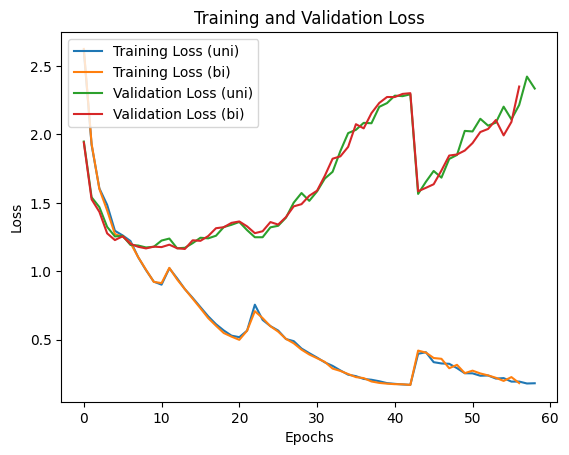

In [20]:
# Extract and store the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

bi_train_loss = bi_history.history['loss']
bi_val_loss = bi_history.history['val_loss']
bi_train_accuracy = bi_history.history['accuracy']
bi_val_accuracy = bi_history.history['val_accuracy']

plt.plot(train_loss, label='Training Loss (uni)')
plt.plot(bi_train_loss, label='Training Loss (bi)')
plt.plot(val_loss, label='Validation Loss (uni)')
plt.plot(bi_val_loss, label='Validation Loss (bi)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

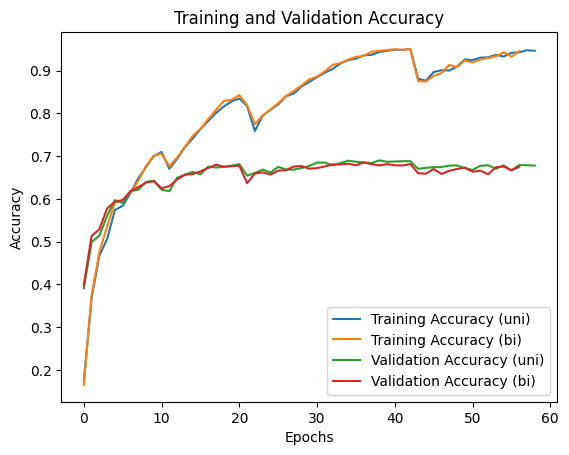

In [32]:
plt.plot(train_accuracy, label='Training Accuracy (uni)')
plt.plot(bi_train_accuracy, label='Training Accuracy (bi)')
plt.plot(val_accuracy, label='Validation Accuracy (uni)')
plt.plot(bi_val_accuracy, label='Validation Accuracy (bi)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [33]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
bi_test_loss, bi_test_accuracy = bi_model.evaluate(X_test, y_test)
print(f"Test Loss (uni): {test_loss}")
print(f"Test Accuracy (uni): {test_accuracy}")
print(f"Test Loss (bi): {bi_test_loss}")
print(f"Test Accuracy (bi): {bi_test_accuracy}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.0539 - loss: 3.0174
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6800 - loss: 2.1393
Test Loss (uni): 3.0179760456085205
Test Accuracy (uni): 0.054111406207084656
Test Loss (bi): 2.044313669204712
Test Accuracy (bi): 0.685145914554596
